In [1]:
from google.colab import drive
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout , BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
df = pd.read_csv("/content/drive/MyDrive/NN_Data/train.csv")
df = df.iloc[:, 1:]

wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = re.sub(r'http\S+|www\S+|@\S+|#\S+', '', text)
    text = "".join([char for char in text if char.isalpha() or char.isspace()])


    tokens = word_tokenize(text.lower())

    tokens = [word for word in tokens if word not in stop_words]
    tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

df['Discussion'] = df['Discussion'].apply(preprocess_text)
df = df.dropna()

In [5]:
category_mapping = {'Politics': 0, 'Sports': 1, 'Media': 2, 'Market & Economy': 3, 'STEM': 4}
df['Category'] = df['Category'].map(category_mapping)

In [6]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['Discussion']).toarray()

y = np.array(df['Category'])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

In [7]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [8]:
model_gru = Sequential([

    Bidirectional(GRU(128, activation='tanh', return_sequences=False,
                      kernel_regularizer=l2(0.01))),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),


    Dense(y_train.shape[1], activation='softmax')
])

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_gru.fit(X_train, y_train, epochs=30, batch_size=64,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])

test_loss, test_accuracy = model_gru.evaluate(X_test, y_test, verbose=2)
print(f'Bidirectional LSTM Test Accuracy: {test_accuracy * 100:.2f}%')

model_gru.save('tfidf_gru_model.h5')

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5486 - loss: 4.4447 - val_accuracy: 0.5858 - val_loss: 1.8558
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6557 - loss: 1.4210 - val_accuracy: 0.6411 - val_loss: 1.4762
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6668 - loss: 1.3683 - val_accuracy: 0.6445 - val_loss: 1.3941
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6823 - loss: 1.3209 - val_accuracy: 0.6341 - val_loss: 1.4381
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6861 - loss: 1.3153 - val_accuracy: 0.6325 - val_loss: 1.4163
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6870 - loss: 1.2992 - val_accuracy: 0.6397 - val_loss: 1.4138
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6956 - loss: 1.2608 - val_accuracy: 0.6389 - val_loss: 1.3734
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6982 - loss: 1.2439 - val_acc

Bidirectional LSTM Test Accuracy: 64.47%


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 256)                 │       3,939,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,922,193 (45.48 MB)

 Trainable params: 3,973,893 (15.16 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,947,788 (30.32 MB)

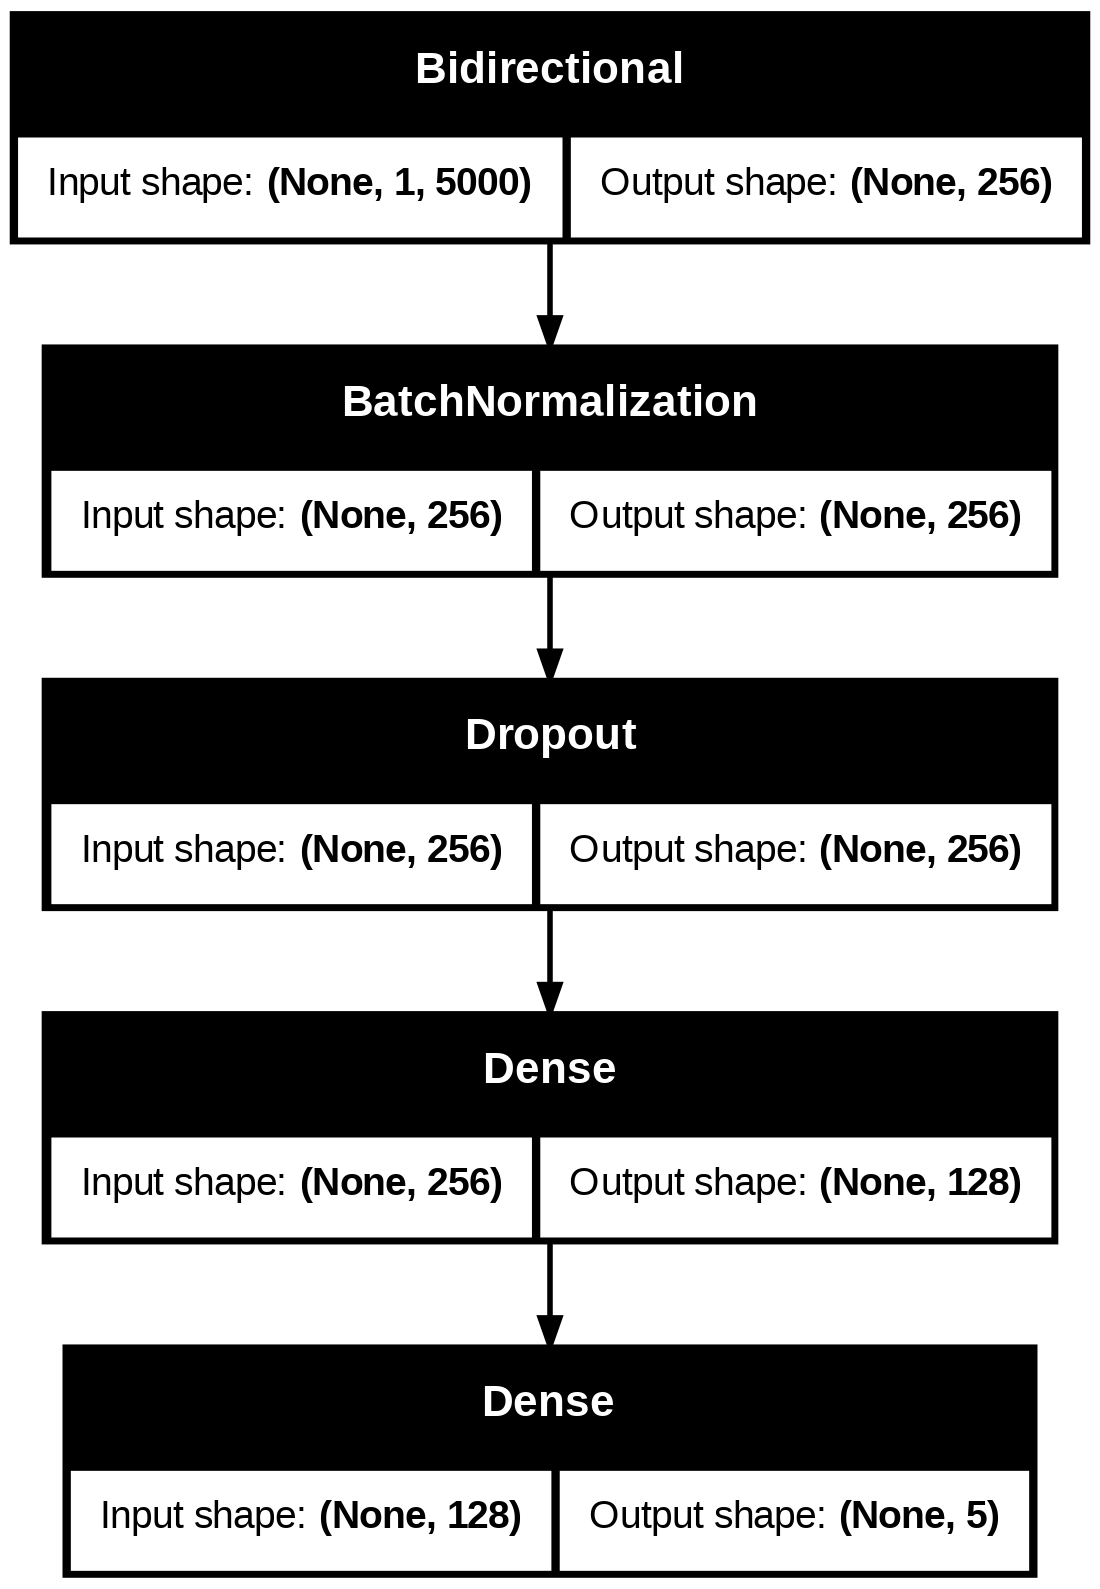

In [10]:

model_gru.summary()
keras.utils.plot_model(model_gru, show_shapes=True)

In [12]:
#testing
test_data = pd.read_csv("/content/drive/MyDrive/NN_Data/test.csv")
test_data['Discussion'] = test_data['Discussion'].apply(preprocess_text)
pred = tfidf_vectorizer.transform(test_data['Discussion']).toarray()

pred = pred.reshape(pred.shape[0], 1, pred.shape[1])
pred = model_gru.predict(pred)
test_predictions = np.argmax(pred, axis=1)
result = pd.DataFrame({
    "SampleID": test_data["SampleID"].values,
    "Category": test_predictions
})
print(result.head(10))
result.to_csv('/content/drive/MyDrive/NN_Data/output.csv', index=False)

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   SampleID  Category
0         1         3
1         2         0
2         3         1
3         4         4
4         5         3
5         6         0
6         7         4
7         8         3
8         9         4
9        10         4
